In [1]:
# Install necessary libraries
!pip install yfinance ta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from ta.volatility import AverageTrueRange, BollingerBands
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=88586f1deccc6794d94cea21a41313a1aefeb7b3a2874a47d1e3f890952a02ff
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [2]:
df = pd.read_csv('dataset.csv')
print("Dataset Loaded Successfully.")

Dataset Loaded Successfully.


In [19]:
df

,Unnamed: 0,open,high,low,close,volume,marketCap,timestamp,crypto_name,date
0,0,112.900002,118.800003,107.142998,115.910004,0.000000e+00,1.288693e+09,2013-05-05T23:59:59.999Z,Bitcoin,05-05-2013
1,1,3.493130,3.692460,3.346060,3.590890,0.000000e+00,6.229819e+07,2013-05-05T23:59:59.999Z,Litecoin,05-05-2013
2,2,115.980003,124.663002,106.639999,112.300003,0.000000e+00,1.249023e+09,2013-05-06T23:59:59.999Z,Bitcoin,06-05-2013
3,3,3.594220,3.781020,3.116020,3.371250,0.000000e+00,5.859436e+07,2013-05-06T23:59:59.999Z,Litecoin,06-05-2013
4,4,112.250000,113.444000,97.699997,111.500000,0.000000e+00,1.240594e+09,2013-05-07T23:59:59.999Z,Bitcoin,07-05-2013
...,...,...,...,...,...,...,...,...,...,...
72941,72941,0.022604,0.022988,0.022197,0.022796,4.040134e+07,1.652957e+09,2022-10-23T23:59:59.999Z,VeChain,23-10-2022
72942,72942,1.468244,1.530464,1.435415,1.517878,2.844351e+07,1.572825e+09,2022-10-23T23:59:59.999Z,Flow,23-10-2022
72943,72943,4.950431,5.148565,4.945280,5.117206,1.069497e+08,1.559551e+09,2022-10-23T23:59:59.999Z,Filecoin,23-10-2022
72944,72944,0.000233,0.000243,0.000226,0.000239,2.143268e+08,1.576291e+09,2022-10-23T23:59:59.999Z,Terra Classic,23-10-2022


In [20]:
#Data Understanding

df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72946 entries, 0 to 72945
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   72946 non-null  int64  
 1   open         72946 non-null  float64
 2   high         72946 non-null  float64
 3   low          72946 non-null  float64
 4   close        72946 non-null  float64
 5   volume       72946 non-null  float64
 6   marketCap    72946 non-null  float64
 7   timestamp    72946 non-null  object 
 8   crypto_name  72946 non-null  object 
 9   date         72946 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.6+ MB


,0
Unnamed: 0,0
open,0
high,0
low,0
close,0
volume,0
marketCap,0
timestamp,0
crypto_name,0
date,0


Data Preprocessing

In [5]:
def preprocess_data(df):
    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
    df = df.sort_values(['date']) # Removed 'symbol' from sorting

    # Handle missing values
    df = df.fillna(method='ffill').dropna()

    # Data Consistency: Ensure numerical columns are floats
    num_cols = ['open', 'high', 'low', 'close', 'volume', 'marketCap']
    df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

    return df

df = preprocess_data(df)

Exploratory Data Analysis (EDA)

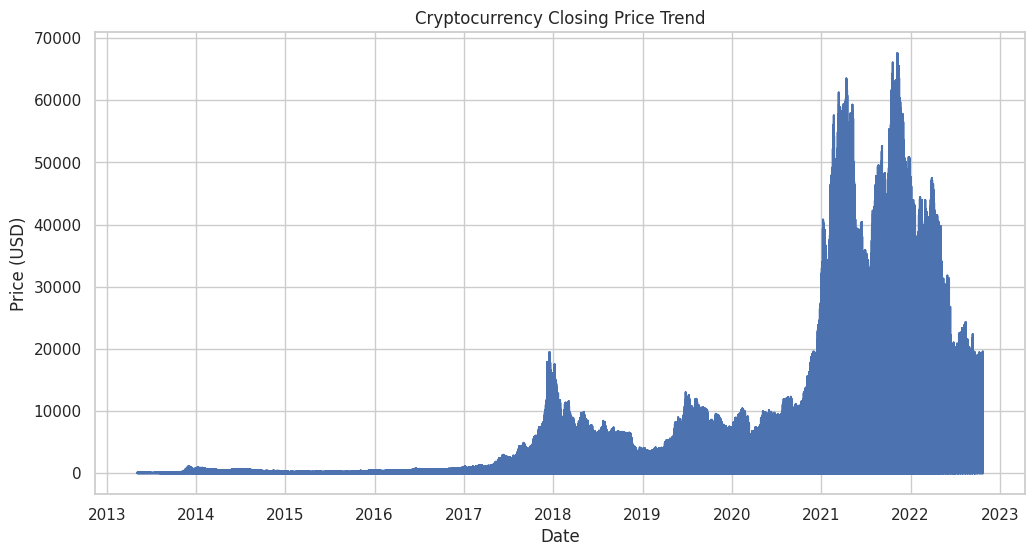

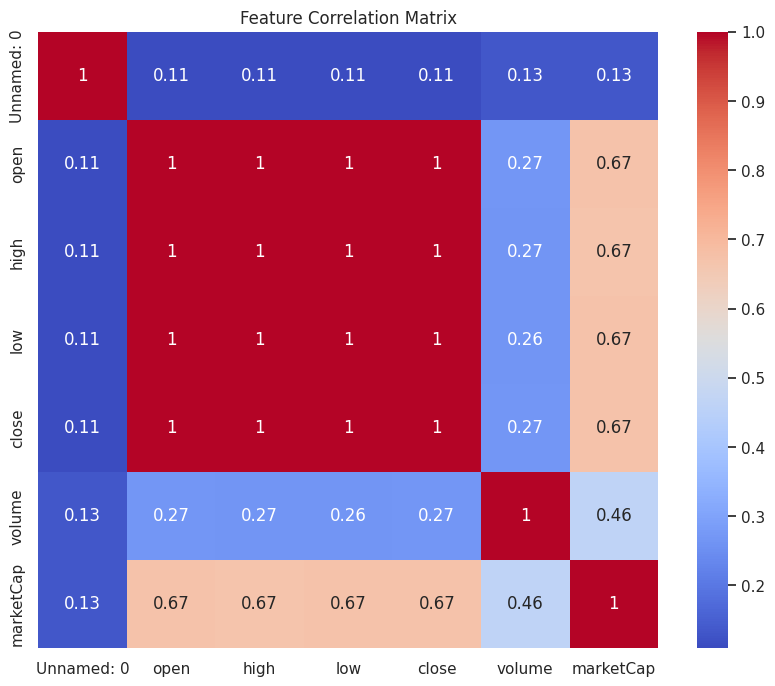

In [8]:
def perform_eda(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df['close'])
    plt.title('Cryptocurrency Closing Price Trend')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.show()

    # Select only numerical columns for correlation matrix
    numerical_df = df.select_dtypes(include=np.number)
    plt.figure(figsize=(10, 8))
    sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm')
    plt.title('Feature Correlation Matrix')
    plt.show()

perform_eda(df)

Feature Engineering

In [11]:
def engineer_features(df):
    # Log Returns
    df['returns'] = np.log(df['close'] / df['close'].shift(1))

    # Target: Rolling Volatility (7-day standard deviation of log returns)
    df['volatility_7d'] = df['returns'].rolling(window=7).std()

    # Moving Averages
    df['MA7'] = df['close'].rolling(window=7).mean()
    df['MA30'] = df['close'].rolling(window=30).mean()

    # Liquidity Ratio (Volume / Market Cap)
    # Add a small epsilon to marketCap to prevent division by zero, which results in inf
    df['liquidity_ratio'] = df['volume'] / (df['marketCap'] + 1e-9)

    # ATR (Average True Range) - Simplified
    df['TR'] = np.maximum(df['high'] - df['low'],
                          np.maximum(abs(df['high'] - df['close'].shift(1)),
                                     abs(df['low'] - df['close'].shift(1))))
    df['ATR'] = df['TR'].rolling(window=14).mean()

    # Bollinger Bands
    df['BB_middle'] = df['close'].rolling(window=20).mean()
    df['BB_std'] = df['close'].rolling(window=20).std()
    df['BB_upper'] = df['BB_middle'] + (df['BB_std'] * 2)
    df['BB_lower'] = df['BB_middle'] - (df['BB_std'] * 2)

    # Lagged Volatility (To predict future volatility)
    df['target'] = df['volatility_7d'].shift(-1)

    # Replace infinite values with NaN before dropping rows
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    return df.dropna()

df_features = engineer_features(df)

Model Selection, Training, and Evaluation

In [25]:
# Define Features and Target
features = ['open', 'high', 'low', 'close', 'volume', 'marketCap', 'MA7', 'MA30', 'liquidity_ratio', 'ATR', 'BB_upper', 'BB_lower']
X = df_features[features]
y = df_features['target']

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)

# Train Model (Random Forest Regressor)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

In [22]:
#Model Training
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [26]:
#Model Evaluation
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R2 Score:", r2)

#How to check accuracy of the code in Colab
#RMSE  → lower is better
#MAE   → lower is better
#R²    → closer to 1 is better

RMSE: 1.7659448255656442
MAE: 1.410607130647262
R2 Score: 0.22899601497552213


Model Optimization (Hyperparameter Tuning)

In [23]:
#Hyperparameter Tuning
params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.05]
}

grid = GridSearchCV(
    XGBRegressor(random_state=42),
    params,
    cv=3,
    scoring='neg_mean_squared_error'
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_

In [27]:
#Saving Model
joblib.dump(best_model, "crypto_volatility_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [28]:
#FastAPI Deployment
%%writefile app.py
from fastapi import FastAPI
import joblib
import numpy as np

app = FastAPI()

model = joblib.load("crypto_volatility_model.pkl")
scaler = joblib.load("scaler.pkl")

@app.post("/predict")
def predict(data: list):
    scaled = scaler.transform([data])
    prediction = model.predict(scaled)
    return {"Predicted Volatility": float(prediction[0])}


Writing app.py


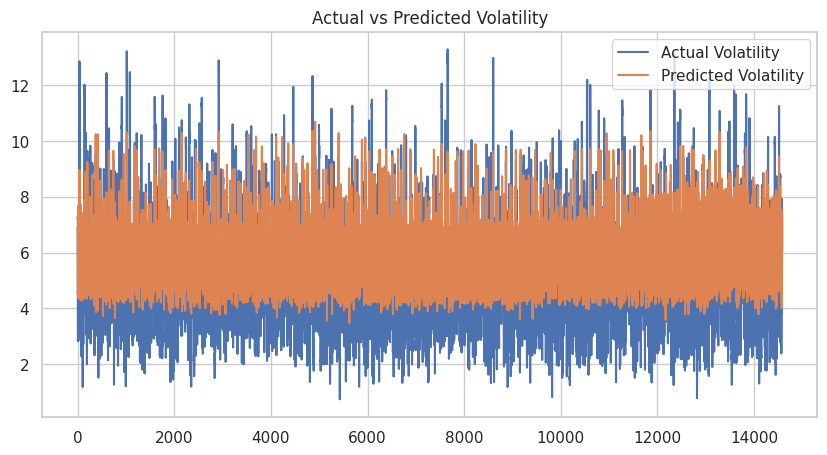

In [29]:
#Actual vs Predicted

plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="Actual Volatility")
plt.plot(y_pred, label="Predicted Volatility")
plt.legend()
plt.title("Actual vs Predicted Volatility")
plt.show()


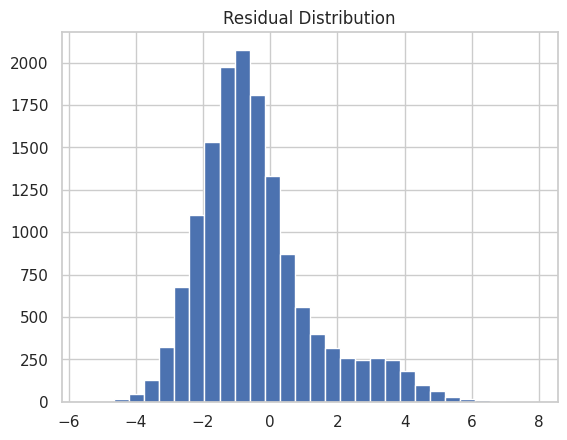

In [30]:
#Residual Analysis

residuals = y_test - y_pred
plt.hist(residuals, bins=30)
plt.title("Residual Distribution")
plt.show()
